In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils import to_categorical
from tensorflow_estimator.python.estimator import early_stopping

#tf.config.set_visible_devices([], 'GPU')

In [2]:
with open('train.txt') as f:
    train_data = f.read()
    

with open('test.txt') as f:
    test_data = f.read()
    
with open('val.txt') as f:
    val_data = f.read()

In [3]:
def prepare_dataset(s):
    text_array = s.split('\n')
    text_list = []
    emotion_list = []
    
    for item in text_array:
        if ";" in item:
            text, emotion = item.split(';')
            text_list.append(text)
            emotion_list.append(emotion)
    return text_list, emotion_list

In [4]:
from tensorflow import keras
from tensorflow.keras import backend as K

def get_model_metrics(test_labels, preds):
    
    # Convert predictions to tensor
    preds = K.constant(preds)
    
    # Calculate Accuracy
    accuracy = keras.metrics.Accuracy()
    accuracy.update_state(test_labels, preds)
    accuracy_result = accuracy.result().numpy()

    # Calculate Precision
    precision = keras.metrics.Precision()
    precision.update_state(test_labels, preds)
    precision_result = precision.result().numpy()

    # Calculate Recall
    recall = keras.metrics.Recall()
    recall.update_state(test_labels, preds)
    recall_result = recall.result().numpy()

    # Calculate F1 Score
    if precision_result + recall_result > 0:
        f1_score = 2 * ((precision_result * recall_result) / (precision_result + recall_result))
    else:
        f1_score = 0

    return {
        "accuracy":accuracy_result, 
        "precision":precision_result,
        'recall': recall_result, 
        "f1_score": f1_score
    }

In [5]:
train_text, train_labels = prepare_dataset(train_data)
test_text, test_labels = prepare_dataset(test_data)
val_text, val_labels = prepare_dataset(val_data)

In [6]:
train_text[:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [7]:
pd.Series(train_labels).value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels_le = le.fit_transform(train_labels)
val_labels_le = le.fit_transform(val_labels)
test_labels_le = le.fit_transform(test_labels)

In [9]:
pd.Series(train_labels_le).value_counts()

2    5362
4    4666
0    2159
1    1937
3    1304
5     572
Name: count, dtype: int64

In [13]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
max_vocab_length = 10000


In [14]:
import os
def create_model_checkpoint(model_name, save_path='model_experiements'):
  return tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(save_path, model_name),
      save_best_only=True,
      verbose=0
  )
# Usage:

In [15]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

# Sequencing and Padding
train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(val_text)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [16]:
train_labels = to_categorical(train_labels_le)
val_labels = to_categorical(val_labels_le)
test_labels = to_categorical(test_labels_le)


In [17]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_padded, train_labels)
).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (validation_padded,val_labels)
).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_padded, test_labels)
).batch(32).prefetch(tf.data.AUTOTUNE)

2024-01-30 17:38:29.585446: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-01-30 17:38:29.585467: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-30 17:38:29.585472: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-30 17:38:29.585508: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-30 17:38:29.585526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
max_words = 10000
embedding_dim = 64

In [19]:
from tensorflow.keras import layers
tf.random.set_seed(42)
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,))
x = layers.Embedding(max_words, embedding_dim, input_length=120)(inputs)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(len(le.classes_), activation="softmax")(x)
model = tf.keras.Model(inputs, outputs, name="dense_model")
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
mod_1_hist = model.fit(train_ds, epochs=25, validation_data=val_ds,verbose=0,callbacks=[create_model_checkpoint(model.name)])

2024-01-30 17:39:02.195790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


INFO:tensorflow:Assets written to: model_experiements/dense_model/assets


In [20]:
model = tf.keras.models.load_model('model_experiements/dense_model')
model.evaluate(test_ds, verbose=0)

[0.40992501378059387, 0.8544999957084656]

In [21]:
preds = model.predict(test_padded)
preds = tf.cast(tf.argmax(preds, axis=1), tf.float32)
mod_1_results = get_model_metrics(test_labels_le, preds)
mod_1_results

63/63 [==============================] - 0s 2ms/step


{'accuracy': 0.8545,
 'precision': 0.975,
 'recall': 0.9721739,
 'f1_score': 0.9735849499702454}

In [22]:

inputs=layers.Input(shape=(1,))
x = layers.Embedding(max_words, embedding_dim, input_length=120)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)  # Dropout for regularization
x = layers.Bidirectional(layers.LSTM(32))(x)
outputs = layers.Dense(len(le.classes_), activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs, name='model_bidirectional')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
mod_2_hist = model.fit(train_ds, epochs=5, validation_data=val_ds, verbose=0, callbacks=[create_model_checkpoint(model.name)])

INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


INFO:tensorflow:Assets written to: model_experiements/model_bidirectional/assets


In [23]:
model = tf.keras.models.load_model('model_experiements/model_bidirectional')
model.evaluate(test_ds)

63/63 [==============================] - 2s 26ms/step - loss: 0.3357 - accuracy: 0.8715


[0.33569854497909546, 0.8715000152587891]

In [24]:
preds = model.predict(test_padded)
preds = tf.cast(tf.argmax(preds, axis=1), tf.float32)
mod_2_results = get_model_metrics(test_labels_le, preds)
mod_2_results

63/63 [==============================] - 2s 21ms/step


{'accuracy': 0.8715,
 'precision': 0.9811765,
 'recall': 0.9669565,
 'f1_score': 0.9740145802497864}

In [25]:


from tensorflow.keras import regularizers

# An example of a simplified model (with one convolutional layer removed)
inputs=layers.Input(shape=(120,))
x = layers.Embedding(max_words, embedding_dim, input_length=120)(inputs)
x = layers.Conv1D(64, 5, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(le.classes_), activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs, name='model_simplified_conv1d')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
mod_3_hist = model.fit(train_ds, epochs=5, validation_data=val_ds, verbose=0, callbacks=[create_model_checkpoint(model.name)])

INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


INFO:tensorflow:Assets written to: model_experiements/model_simplified_conv1d/assets


In [26]:
model = tf.keras.models.load_model('model_experiements/model_simplified_conv1d')
model.evaluate(test_ds)

63/63 [==============================] - 1s 8ms/step - loss: 0.3324 - accuracy: 0.8715


[0.3323591649532318, 0.8715000152587891]

In [27]:
preds = model.predict(test_padded)
preds = tf.cast(tf.argmax(preds, axis=1), tf.float32)
mod_3_results = get_model_metrics(test_labels_le, preds)
mod_3_results

63/63 [==============================] - 0s 2ms/step


{'accuracy': 0.8715,
 'precision': 0.9751589,
 'recall': 0.97855073,
 'f1_score': 0.9768518209457397}

In [29]:
# Shared Input Layer

from tensorflow.keras import regularizers

inputs = layers.Input(shape=(120,))

# Branch 1
branch1 = layers.Embedding(max_words, embedding_dim, input_length=120)(inputs)
branch1 = layers.Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(branch1)
branch1 = layers.BatchNormalization()(branch1)
branch1 = layers.ReLU()(branch1)
branch1 = layers.Dropout(0.5)(branch1)
branch1 = layers.GlobalMaxPooling1D()(branch1)

# Branch 2
branch2 = layers.Embedding(max_words, embedding_dim, input_length=120)(inputs)
branch2 = layers.Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(branch2)
branch2 = layers.BatchNormalization()(branch2)
branch2 = layers.ReLU()(branch2)
branch2 = layers.Dropout(0.5)(branch2)
branch2 = layers.GlobalMaxPooling1D()(branch2)

# Concatenation and Hidden Layer
concatenated = layers.Concatenate()([branch1, branch2])
hid_layer = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(concatenated)
dropout = layers.Dropout(0.5)(hid_layer)

# Output Layer
output_layer = layers.Dense(6, activation='softmax')(dropout)

# Final Model
model = tf.keras.Model(inputs, output_layer, name='branch_model')

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
mod_4_hist = model.fit(train_ds, epochs=5, validation_data=val_ds, verbose=0, callbacks=[create_model_checkpoint(model.name)])

INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


INFO:tensorflow:Assets written to: model_experiements/branch_model/assets


In [31]:
model = tf.keras.models.load_model('model_experiements/branch_model')
model.evaluate(test_ds)

63/63 [==============================] - 2s 27ms/step - loss: 0.4798 - accuracy: 0.8665


[0.47978949546813965, 0.8665000200271606]

In [32]:
preds = model.predict(test_padded)
preds = tf.cast(tf.argmax(preds, axis=1), tf.float32)
mod_4_results = get_model_metrics(test_labels_le, preds)
mod_4_results

63/63 [==============================] - 0s 4ms/step


{'accuracy': 0.8665,
 'precision': 0.96966225,
 'recall': 0.98202896,
 'f1_score': 0.975806474685669}

In [33]:
index = ['Dense Model', 'Bidirectional Model', 'Conv1D Model', 'Branch Conv1D Model']
results_df = pd.DataFrame([
    mod_1_results,
    mod_2_results,
    mod_3_results,
    mod_4_results
])

results_df.index = index
results_df

,accuracy,precision,recall,f1_score
Dense Model,0.8545,0.975000,0.972174,0.973585
Bidirectional Model,0.8715,0.981176,0.966956,0.974015
Conv1D Model,0.8715,0.975159,0.978551,0.976852
Branch Conv1D Model,0.8665,0.969662,0.982029,0.975806


In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    best_epoch = np.argmin(val_loss)  # get the epoch with the lowest validation loss
    best_accuracy_epoch = np.argmax(val_accuracy)  # get the epoch with the highest validation accuracy
    
    # Create a figure
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)  # use two subplots: one for loss and one for accuracy
    
    # Plot losses
    ax1.plot(loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.axvline(best_epoch, color='r', linestyle='--', label='Best Epoch')
    ax1.legend()
    ax1.set_title('Loss Values')

    # Plot accuracies
    ax2.plot(accuracy, label='Training Accuracy')
    ax2.plot(val_accuracy, label='Validation Accuracy')
    ax2.axvline(best_accuracy_epoch, color='r', linestyle='--', label='Best Epoch')
    ax2.legend()
    ax2.set_title('Accuracy Values')
    
    # Show the figure
    plt.xlabel('Epochs')
    fig.tight_layout()
    plt.show()

# Assume you have a history after fit a model
# history = model.fit(...)# plot_history(history)

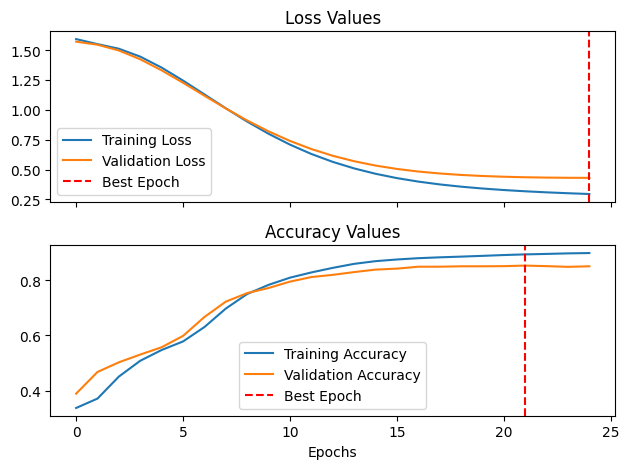

In [35]:
# Dense Model History
plot_history(mod_1_hist)

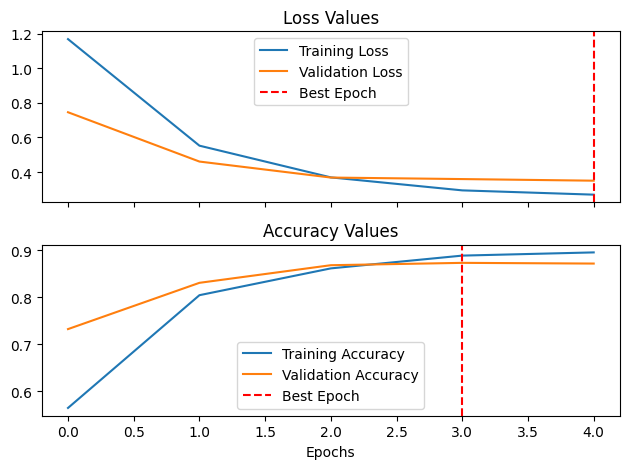

In [36]:
plot_history(mod_2_hist)

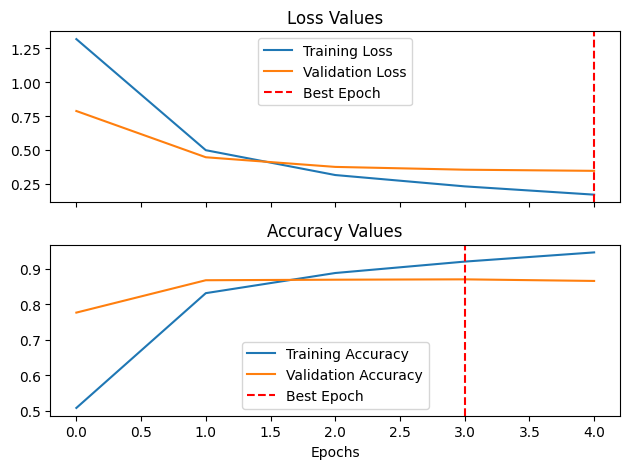

In [37]:
plot_history(mod_3_hist)

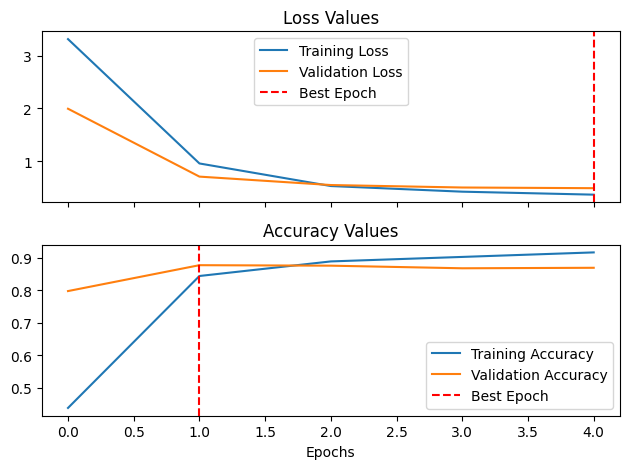

In [38]:
plot_history(mod_4_hist)